In [1]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell 1: Imports & Configuration
# ─────────────────────────────────────────────────────────────────────────────
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from shapely.geometry   import Polygon, MultiPolygon, Point, LineString, MultiLineString
from shapely.ops        import unary_union
from shapely.validation import make_valid
from roifile            import ImagejRoi
from tqdm               import tqdm
from PIL                import Image

# --- Directories --- 
BASE_DIR           = r"D:\PSM\SST_images\SST3"
ROI_DIR            = os.path.join(BASE_DIR, "avg",    "Processed_ROIs")
REFINED_PYR_DIR    = os.path.join(ROI_DIR,  "refinedPyrimidale")
CSV_DIR            = os.path.join(BASE_DIR, "csvs")
AVG_DIR            = os.path.join(BASE_DIR, "avg")
AVG_BC_DIR         = os.path.join(AVG_DIR,  "BC_corrected")
RESULTS_XLSX       = os.path.join(BASE_DIR, "results", "processed_results.xlsx")
ROI_MEASURE_CSV    = os.path.join(AVG_DIR,  "roi_measurements.csv")

# --- Parameters ---
VOLUME_CUTOFF = 80                  # µm³
PSM_LETTERS   = list("EFIKLMNOPQSTUW")   # iterate letters
PSM_NUMBERS   = range(1,6)          # iterate numbers 1–5
GROUP_C       = set(['K','L','M','N','O','P','Q'])
GROUP_SE      = set(['E','F','I','S','T','U','W'])


In [2]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell 2: Helper Functions
# ─────────────────────────────────────────────────────────────────────────────
def _make_valid(poly: Polygon|MultiPolygon):
    if poly.is_valid: return poly
    fixed = poly.buffer(0)
    return fixed if fixed.is_valid else make_valid(poly)

def _outer_boundary(poly: Polygon|MultiPolygon):
    if isinstance(poly, Polygon): return poly.exterior
    return unary_union([p.exterior for p in poly.geoms])

def round_coords(coords):
    return np.round(coords).astype(int)

def save_pyr_roi(poly, out_dir, base_id):
    os.makedirs(out_dir, exist_ok=True)
    pts = round_coords(np.array(poly.exterior.coords))
    ImagejRoi.frompoints(pts).tofile(
        os.path.join(out_dir, f"Red_{base_id}_s_pyrimidale.roi")
    )

def extract_shared_boundary(p1,p2):
    b = p1.intersection(p2)
    if b.is_empty: return None
    if b.geom_type in ("LineString","MultiLineString"): return b
    if b.geom_type=="GeometryCollection":
        lines=[g for g in b.geoms if g.geom_type in ("LineString","MultiLineString")]
        return MultiLineString(lines) if lines else None
    return None

def generate_file_paths(base_id):
    return {
        "full_roi"   : os.path.join(ROI_DIR,  f"Red_{base_id}_full.roi"),
        "oriens_roi" : os.path.join(ROI_DIR,  f"Red_{base_id}_s_oriens.roi"),
        "radiatum_roi":os.path.join(ROI_DIR,  f"Red_{base_id}_s_radiatum.roi")
    }

def create_base_id(letter,number):
    return f"PSM_{letter}_CA1_10x_{str(number).zfill(2)}"

def process_rois(base_id):
    fps = generate_file_paths(base_id)
    try:
        full = _make_valid(Polygon(round_coords(
            ImagejRoi.fromfile(fps["full_roi"]).coordinates())))
        ori  = _make_valid(Polygon(round_coords(
            ImagejRoi.fromfile(fps["oriens_roi"]).coordinates())))
        rad  = _make_valid(Polygon(round_coords(
            ImagejRoi.fromfile(fps["radiatum_roi"]).coordinates())))
        pyr  = _make_valid(full.difference(unary_union([ori,rad])))
        save_pyr_roi(pyr, REFINED_PYR_DIR, base_id)
        return {"full":full,"oriens":ori,"pyrimidale":pyr,"radiatum":rad}
    except Exception as e:
        print(f"Error processing ROIs for {base_id}: {e}")
        return None

def calculate_shared_boundaries(polys):
    sb = {
        ('oriens','pyrimidale')   : extract_shared_boundary(polys['oriens'],polys['pyrimidale']),
        ('pyrimidale','radiatum'): extract_shared_boundary(polys['pyrimidale'],polys['radiatum']),
    }
    for k,b in sb.items():
        status = "valid" if b and not b.is_empty else "invalid/empty"
        #print(f"Shared {k}: {status}")
    return sb

def calculate_relative_positions(base_id, points, polys, shared):
    positions = []
    for x, y in points[['X', 'Y']].values:
        pt = Point(x, y)
        assigned = False

        for name in ['oriens', 'pyrimidale', 'radiatum', 'full']:  # priority order
            poly = polys[name]
            if not poly.covers(pt):
                continue

            if name == 'pyrimidale':
                d1 = pt.distance(shared[('oriens', 'pyrimidale')])
                d2 = pt.distance(shared[('pyrimidale', 'radiatum')])
                t = d1 + d2
                pct = (d1 / t) * 100 if t else None
            elif name in ['oriens', 'radiatum']:
                key = ('oriens', 'pyrimidale') if name == 'oriens' else ('pyrimidale', 'radiatum')
                sb = shared.get(key)
                if not sb or sb.is_empty:
                    continue
                outer = _outer_boundary(poly)
                adj = outer.difference(sb)
                d1 = pt.distance(sb)
                d2 = pt.distance(adj)
                t = d1 + d2
                pct = (d1 / t) * 100 if t else None
            else:
                pct = None

            positions.append({'X': x, 'Y': y, 'ROI': name, 'Position%': pct})
            assigned = True
            break

        if not assigned:
            print("Point (%.1f, %.1f) not assigned to any ROI" % (x, y))

    return positions

In [3]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell 3: Batch Processing (ROIs → Distances → Excel), including X/Y coords
#           (Keep “radiatum” only if label==1; keep all non‐radiatum)
# ─────────────────────────────────────────────────────────────────────────────
import os
import numpy as np
import pandas as pd
from shapely.geometry import Point

# (Assume Cells 1 & 2 have defined BASE_DIR, ROI_DIR, CSV_DIR, VOLUME_CUTOFF, 
#  PSM_LETTERS, PSM_NUMBERS, GROUP_C, GROUP_SE, and all helper‐functions 
#  (_make_valid, generate_file_paths, process_rois, calculate_shared_boundaries, 
#   calculate_relative_positions, etc.) are already in scope.)

# ─── LOAD THE LABEL‐MAP (for radiatum cells) ─────────────────────────────────
MODEL_DIR     = r"D:\PSM\SST_images\SST3\models"
LABEL_MAP_CSV = os.path.join(MODEL_DIR, "radiatum_label_map.csv")

# radiatum_label_map.csv must contain three columns: 
#    base_id (string), obj_idx (int), label (0 or 1)
try:
    label_map_df = pd.read_csv(LABEL_MAP_CSV, dtype={"base_id": str, "obj_idx": int, "label": int})
    if label_map_df.empty:
        print("⚠️ radiatum_label_map.csv is empty — skipping radiatum filtering.")
        label_map_df = None
except FileNotFoundError:
    print("⚠️ radiatum_label_map.csv not found — keeping all radiatum objects unfiltered.")
    label_map_df = None


# ─── START BATCH PROCESSING ─────────────────────────────────────────────────
all_results = []
log_issues   = []

for letter in PSM_LETTERS:
    for num in PSM_NUMBERS:
        base_id = create_base_id(letter, num)
        rois    = process_rois(base_id)
        if not rois:
            log_issues.append(f"ROI_Error {base_id}")
            continue

        shared = calculate_shared_boundaries(rois)

        # Find the first existing “Statistics_for_Red_<base_id>_<seg>_seg.tif.csv”
        seg_file = None
        for seg in range(1, 10):
            candidate = os.path.join(
                CSV_DIR, f"Statistics_for_Red_{base_id}_{seg}_seg.tif.csv"
            )
            if os.path.exists(candidate):
                seg_file = candidate
                break
        if not seg_file:
            log_issues.append(f"CSV_Missing {base_id}")
            continue

        # ─── Read per‐stack CSV and assign a zero‐based obj_idx before filtering ──
        pts = pd.read_csv(seg_file)
        pts["obj_idx"] = np.arange(len(pts))   # preserve original index as obj_idx

        # Filter out tiny volumes
        vc = next((c for c in pts.columns if "Volume" in c and "µm" in c), None)
        if not vc:
            log_issues.append(f"Volume_Missing {base_id}")
            continue

        pts = pts[pts[vc] > VOLUME_CUTOFF].copy()
        if pts.empty:
            # No objects above volume cutoff; still record zero‐counts later
            # But skip computing positions (nothing to pass to calculate_relative_positions)
            # We will append placeholder rows below.
            res = []
        else:
            # Compute “Position%” (and get X,Y from pts) for each remaining object
            res = calculate_relative_positions(base_id, pts, rois, shared)
            # res is a list of dicts, each with keys: 'X', 'Y', 'ROI', 'Position%'

        # Build a mapping from the filtered pts → res entries
        #    We assume calculate_relative_positions returns entries in the same order as `pts`.
        #    If pts was empty, res = [].

        counts = {r: 0 for r in ["oriens", "pyrimidale", "radiatum", "full"]}
        if res:
            for i, entry in enumerate(res):
                original_idx = int(pts.iloc[i]["obj_idx"])
                roi_name     = entry["ROI"]
                counts[roi_name] += 1

                all_results.append({
                    "base_id"   : base_id,
                    "obj_idx"   : original_idx,
                    "ROI"       : roi_name,
                    "Position%": entry["Position%"],
                    "X"         : entry["X"],
                    "Y"         : entry["Y"]
                })

        # If NO objects fell into a given ROI, still append a placeholder with X/Y=None
        for roi, count in counts.items():
            if count == 0:
                all_results.append({
                    "base_id"   : base_id,
                    "obj_idx"   : None,           # placeholder
                    "ROI"       : roi,
                    "Position%": None,
                    "X"         : None,
                    "Y"         : None
                })

# ─── Convert to DataFrame ─────────────────────────────────────────────────────
df_all = pd.DataFrame(all_results)

# ─── SPLIT “radiatum” vs “non‐radiatum” rows ─────────────────────────────────
df_rad    = df_all[df_all["ROI"] == "radiatum"].copy()
df_nonrad = df_all[df_all["ROI"] != "radiatum"].copy()

# ─── FILTER RADIATUM: keep only those with label==1 (Cell), via inner‐merge ──
if label_map_df is not None:
    df_rad = (
        df_rad
        .merge(label_map_df, on=["base_id", "obj_idx"], how="inner")
        .query("label == 1")
        .copy()
    )
else:
    # No label map — assume all radiatum rows are valid
    df_rad["label"] = 1

# Now df_rad has columns: [base_id, obj_idx, ROI, Position%, X, Y, label]

# ─── For non‐radiatum rows (oriens & pyrimidale & full), assign label = 1 (all are “Cell”) ─
df_nonrad["label"] = 1

# ─── COMBINE both back together ────────────────────────────────────────────────
df_combined = pd.concat([df_nonrad, df_rad], ignore_index=True)

# ─── ASSIGN “Group” (C vs SE) and SPLIT into df_C, df_SE ──────────────────────
df_combined["Group"] = (
    df_combined["base_id"]
    .str[4:5]  # e.g. “PSM_K_CA1_10x_03” → “K”
    .map(lambda L: "C" if L in GROUP_C else "SE")
)

df_C  = df_combined[df_combined["Group"] == "C"].drop(columns=["Group"])
df_SE = df_combined[df_combined["Group"] == "SE"].drop(columns=["Group"])

# ─── OPTIONAL: Save both sheets (“C” & “SE”) to the same Excel workbook ─────────
with pd.ExcelWriter(RESULTS_XLSX, engine="openpyxl") as writer:
    df_C.to_excel(writer, sheet_name="C", index=False)
    df_SE.to_excel(writer, sheet_name="SE", index=False)

print("Saved processed_results.xlsx (oriens + pyrimidale all + radiatum cells only)")
print("log_issues (first 5):", log_issues[:5])


Error processing ROIs for PSM_W_CA1_10x_03: [Errno 2] No such file or directory: 'D:\\PSM\\SST_images\\SST3\\avg\\Processed_ROIs\\Red_PSM_W_CA1_10x_03_full.roi'
Saved processed_results.xlsx (oriens + pyrimidale all + radiatum cells only)
log_issues (first 5): ['ROI_Error PSM_W_CA1_10x_03']


In [4]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell 4: Batch Error Summary
# ─────────────────────────────────────────────────────────────────────────────
from collections import defaultdict
summary = defaultdict(list)
for err in log_issues:
    typ, bid = err.split(" ",1)
    summary[typ].append(bid)

print("=== Batch Error Summary ===")
for typ, bids in summary.items():
    print(f"{typ} ({len(bids)}): {', '.join(bids)}")


=== Batch Error Summary ===
ROI_Error (1): PSM_W_CA1_10x_03


In [5]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell 5 (revised): ROI Areas & Group Densities by Group (cells only)
# ─────────────────────────────────────────────────────────────────────────────

# 1) Load the measured ROI areas CSV
roi_df = pd.read_csv(ROI_MEASURE_CSV)

# 2) Extract the BaseID (e.g. "PSM_B_CA1_10x_04")
roi_df['BaseID'] = roi_df['Filename'].str.extract(r'(PSM_[A-Z]_CA1_10x_\d{2})')[0]

# 3) Pivot to get one column per ROI type
pivot = (
    roi_df
    .pivot_table(index='BaseID', columns='ROI', values='Area (microns)', aggfunc='sum')
    .reset_index()
)

# 4) Rename the columns containing the substrings to standard names
rename_map = {
    col: (
        'Area_full'        if 'full'       in col.lower() else
        'Area_oriens'      if 'oriens'     in col.lower() else
        'Area_pyrimidale'  if 'pyrimidale' in col.lower() else
        'Area_radiatum'    if 'radiatum'   in col.lower() else
        col
    )
    for col in pivot.columns
}
pivot = pivot.rename(columns=rename_map)

# 5) Extract the PSM letter and sum areas per letter
pivot['PSM_Letter'] = pivot['BaseID'].str.split('_').str[1]
areas_by_letter = pivot.groupby('PSM_Letter')['Area_full'].sum().to_dict()

print("Areas by letter (µm²):", areas_by_letter)

# 6) Aggregate into groups C and SE
group_areas = {
    'C' : sum(areas_by_letter.get(l, 0) for l in GROUP_C),
    'SE': sum(areas_by_letter.get(l, 0) for l in GROUP_SE),
}

print("Group Areas (µm²):", group_areas)

# 7) Total cells per group (df_C, df_SE already in scope from Cell 3)
counts = {'C': len(df_C), 'SE': len(df_SE)}
print("Total cells:", counts)

# 8) Compute densities in cells/mm²
group_densities = {}
for g in ['C','SE']:
    area_um2 = group_areas[g]
    if area_um2 <= 0:
        raise ValueError(f"Group {g} has zero total area — cannot compute density.")
    # convert µm² → mm² by × 1e–6
    group_densities[g] = counts[g] / (area_um2 * 1e-6)

print("Densities (cells/mm²):", group_densities)

Areas by letter (µm²): {'A': 2897309.9288, 'B': 2806267.1985, 'C': 2606045.7171, 'D': 2659171.1104, 'E': 2555873.9651, 'F': 2275191.0568, 'G': 2711417.2366, 'H': 2978076.0368999997, 'I': 2697739.7498, 'J': 2867200.065, 'K': 3169518.0274, 'L': 2916325.2617, 'M': 2785109.7158000004, 'N': 2916360.0576, 'O': 4174669.4215, 'P': 4106535.8127, 'Q': 4516030.7616, 'R': 3465739.2103000004, 'S': 3641561.0652, 'T': 3887828.2829, 'U': 4439623.5074000005, 'V': 4602662.994, 'W': 3543950.8724}
Group Areas (µm²): {'C': 24584549.0583, 'SE': 23041768.4996}
Total cells: {'C': 2005, 'SE': 1661}
Densities (cells/mm²): {'C': 81.55528886233897, 'SE': 72.08648068957183}


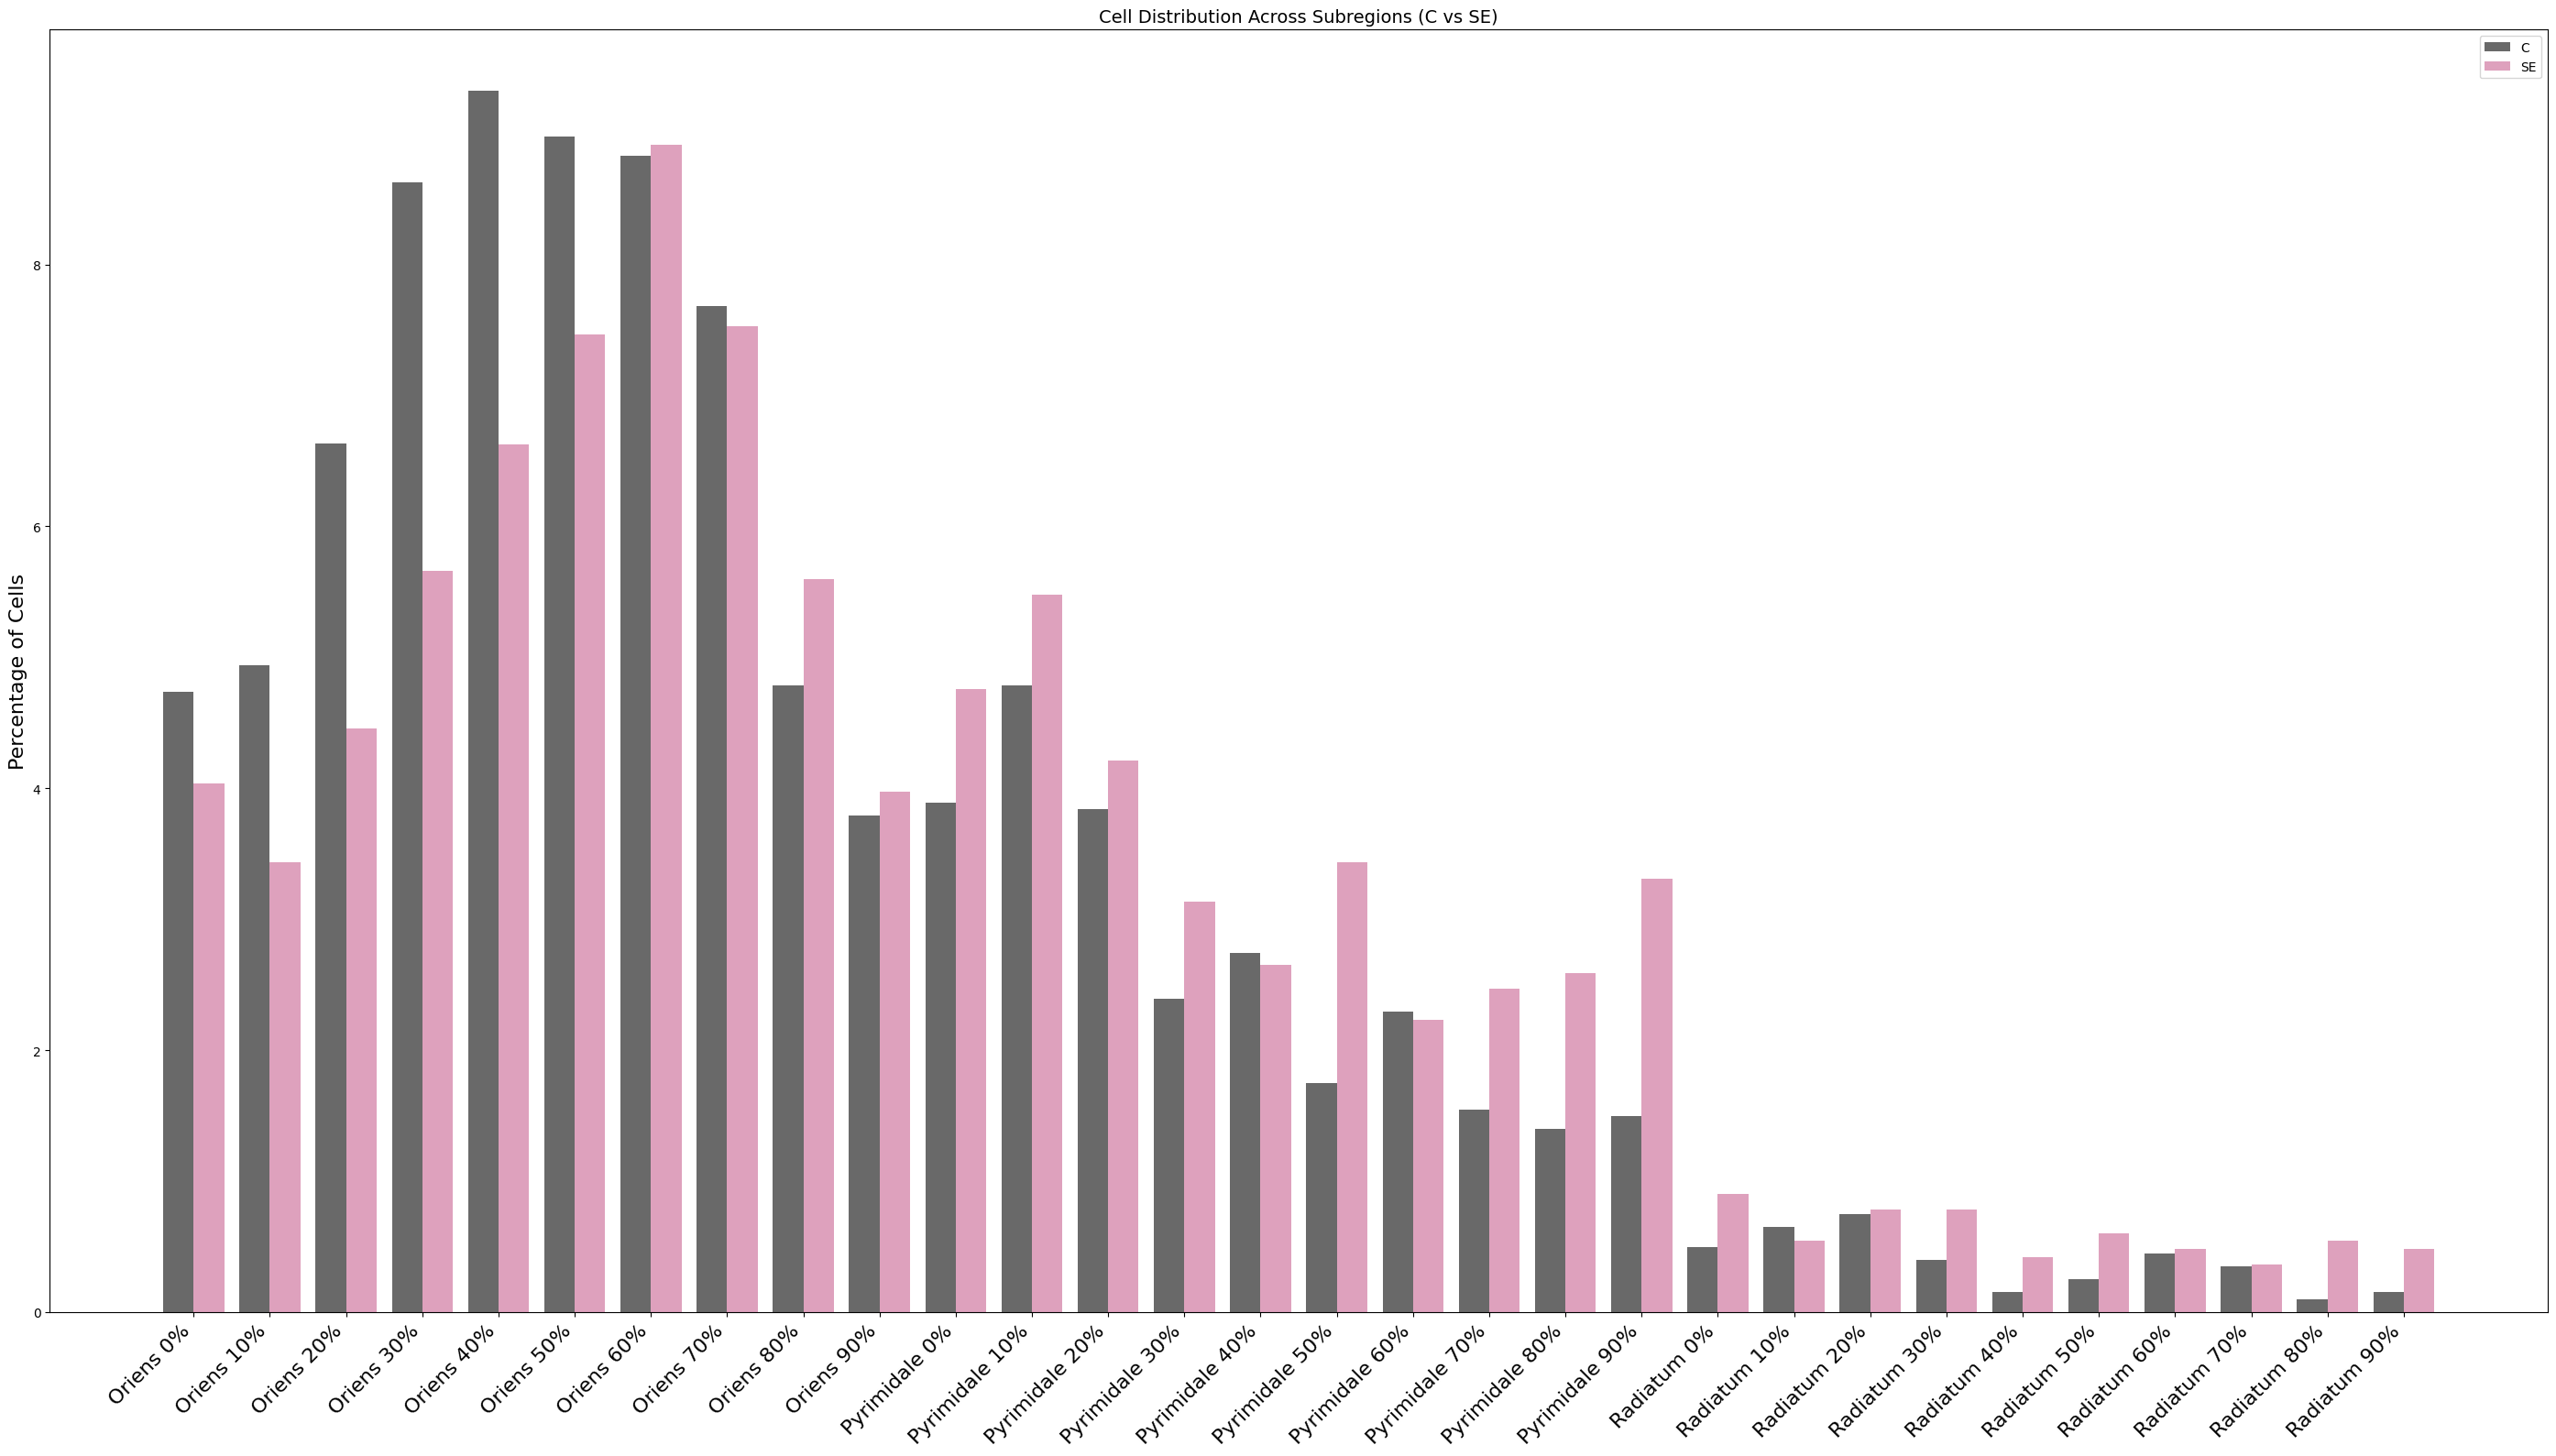

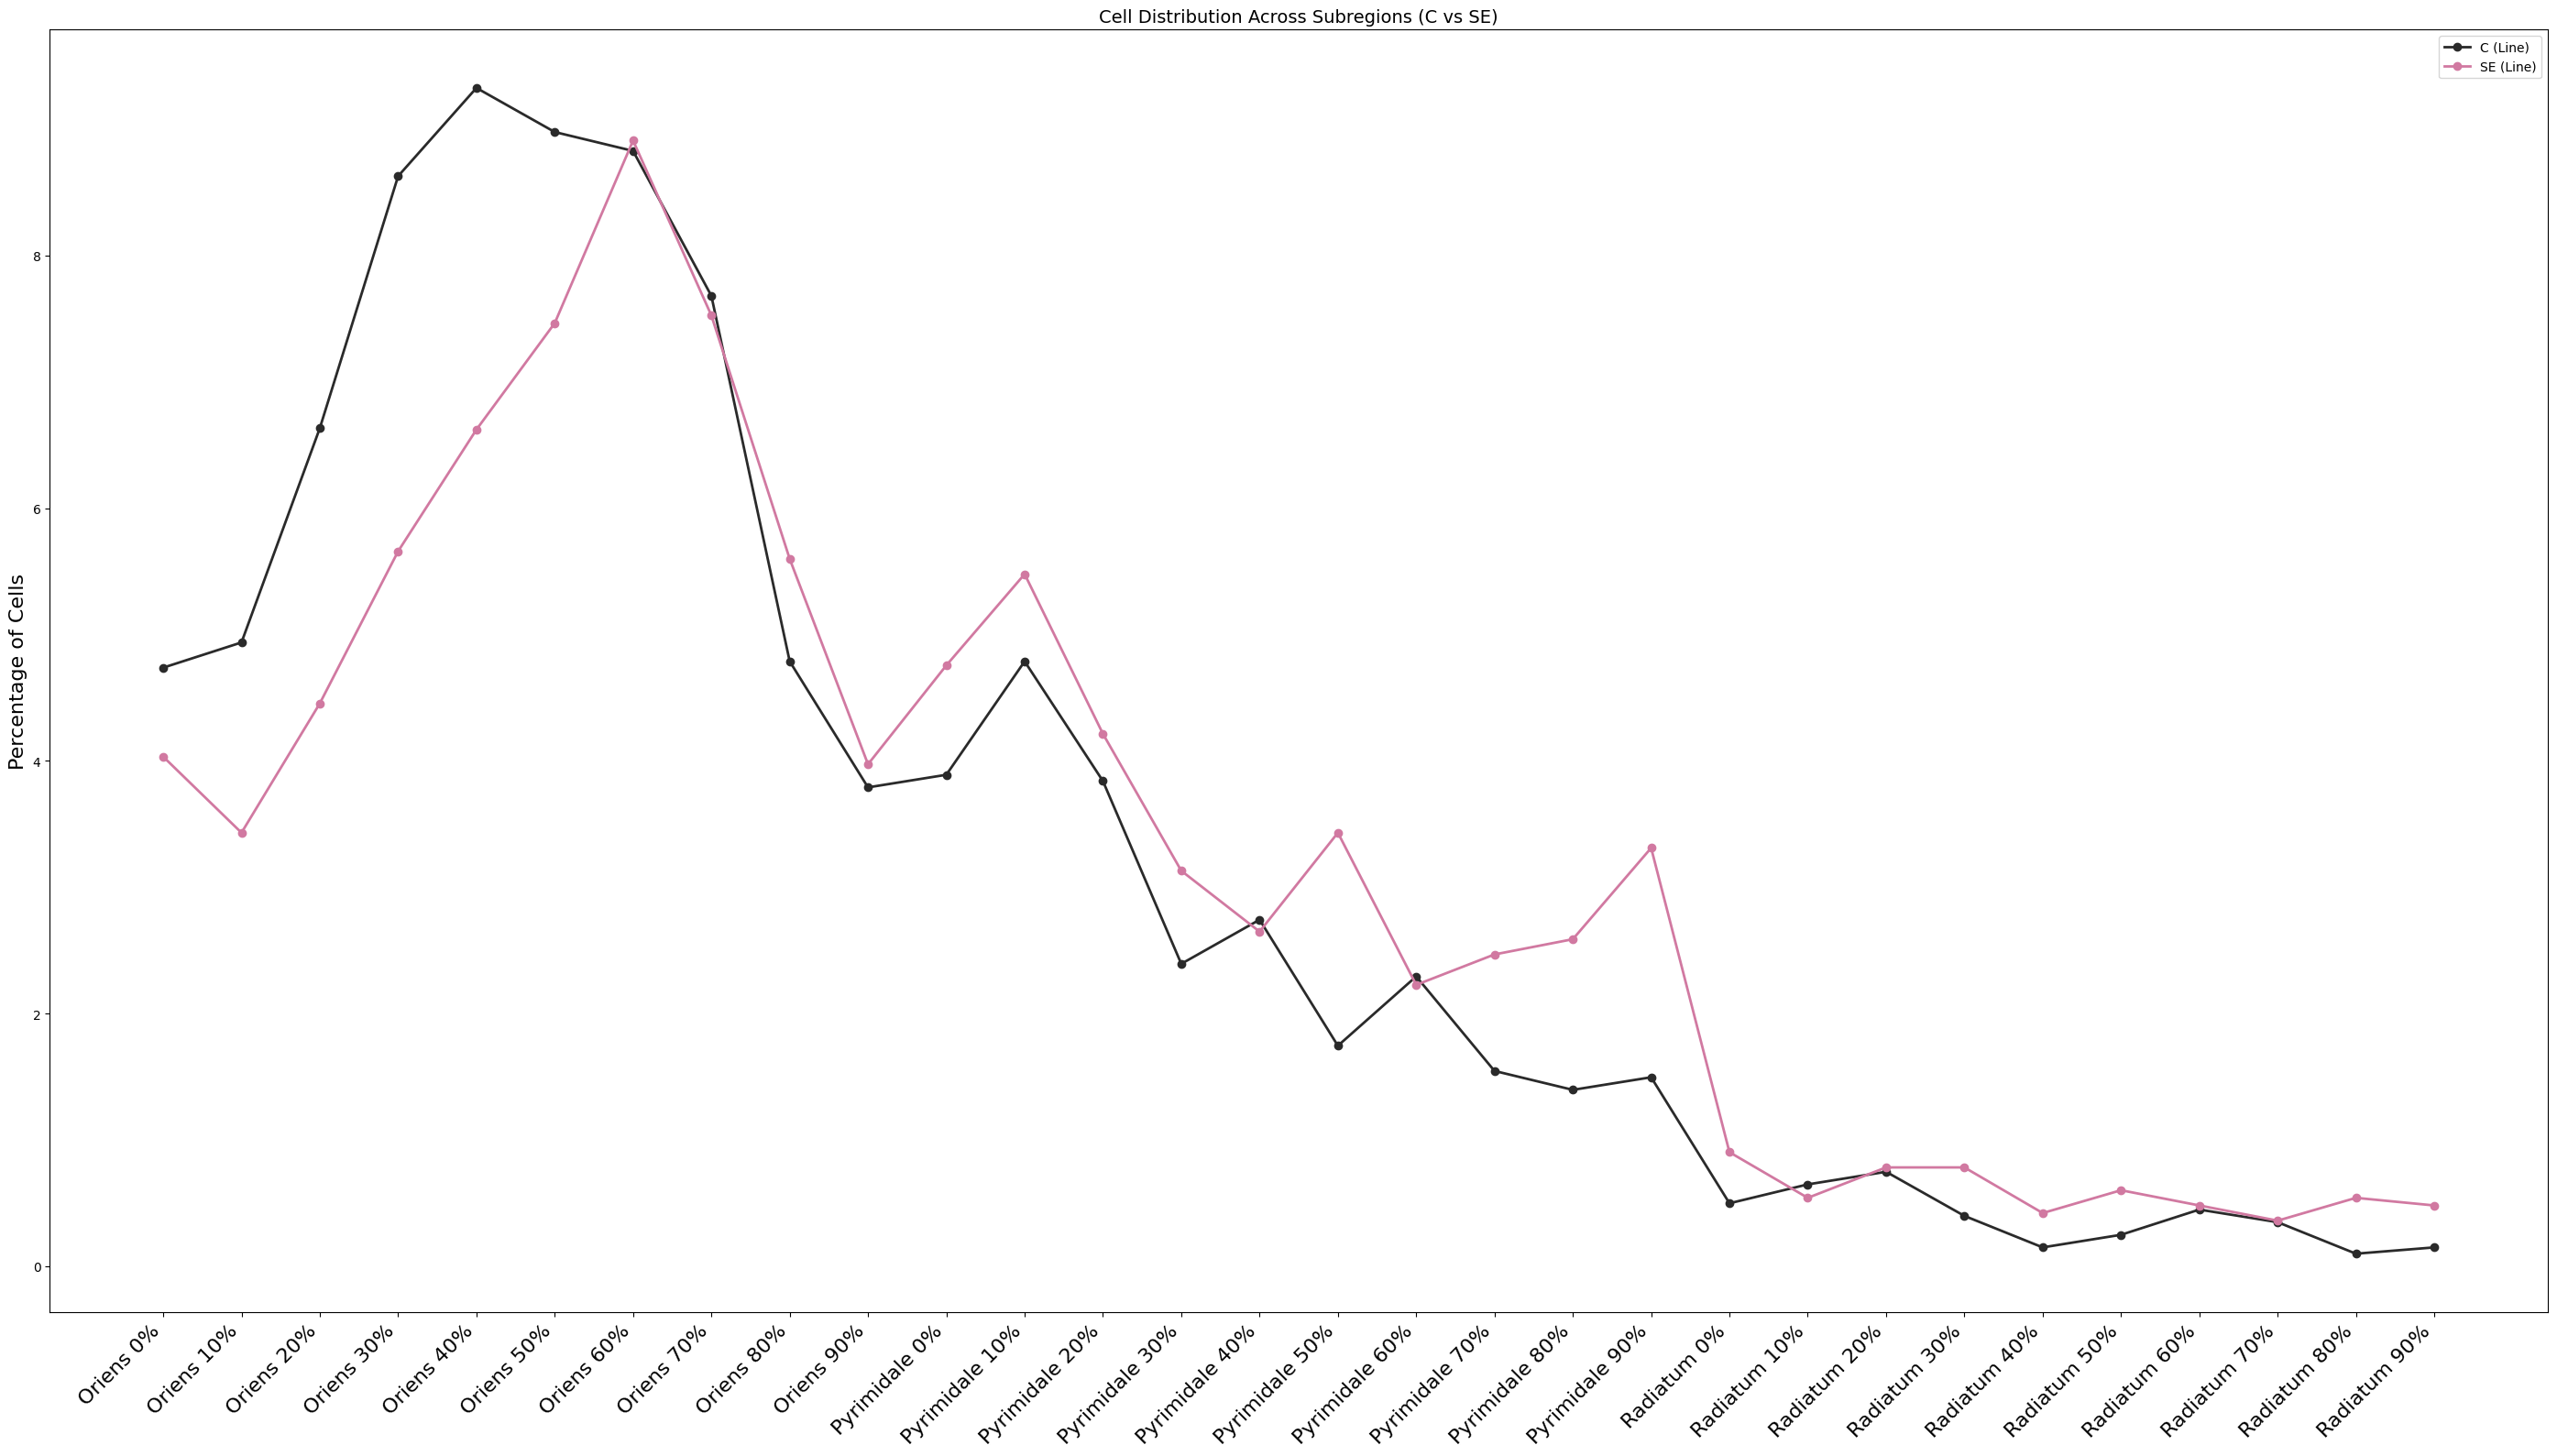

Saved raw distribution charts →
 • D:\PSM\SST_images\SST3\results\Cell_distribution.png
 • D:\PSM\SST_images\SST3\results\Cell_distribution.svg
 • D:\PSM\SST_images\SST3\results\Cell_distribution_line.png
 • D:\PSM\SST_images\SST3\results\Cell_distribution_line.svg


In [6]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell 6: Distribution Plot with Raw Counts Annotated (cells only)
# ─────────────────────────────────────────────────────────────────────────────

# --- results directory from your config ---
results_dir = os.path.dirname(RESULTS_XLSX)

# --- sub_dist: returns (labels, percent‐of‐cells, raw counts) per bin across the 3 ROIs
def sub_dist(df_in):
    labels, percent, raw = [], [], []
    total = len(df_in)
    if total == 0:
        return [], [], []

    for reg in ['oriens', 'pyrimidale', 'radiatum']:
        bins = np.linspace(0, 100, 11)
        sd = df_in[df_in['ROI'] == reg].copy()
        sd['Bin'] = pd.cut(sd['Position%'], bins=bins,
                           labels=False, include_lowest=True)
        cnt = sd['Bin'].value_counts(sort=False) \
                 .reindex(range(10), fill_value=0)

        raw.extend(cnt.tolist())
        percent.extend((cnt / total) * 100)
        labels += [f"{reg.capitalize()} {i*10}%" for i in range(10)]

    return labels, percent, raw

# --- compute for C and SE (df_C, df_SE already in scope) ---
labels_C, dist_C, raw_C = sub_dist(df_C)
_,        dist_SE, raw_SE = sub_dist(df_SE)

# --- plotting ---
x = np.arange(len(labels_C))
w = 0.4

# Bar Chart
fig, ax = plt.subplots(figsize=(28, 16))
barsC = ax.bar(x - w/2, dist_C, w, label='C', alpha=0.7, color='#2a2a2a')
barsS = ax.bar(x + w/2, dist_SE, w, label='SE', alpha=0.7, color='#d179a1')

ax.set_xticks(x)
ax.set_xticklabels(labels_C, rotation=45, ha='right', fontsize=16)
ax.set_ylabel('Percentage of Cells', fontsize=16)
ax.set_title('Cell Distribution Across Subregions (C vs SE)', fontsize=14)
ax.legend()
fig.tight_layout()

bar_png = os.path.join(results_dir, "Cell_distribution.png")
bar_svg = os.path.join(results_dir, "Cell_distribution.svg")
fig.savefig(bar_png, dpi=300)
fig.savefig(bar_svg)
plt.show()

# Line Chart
fig2, ax2 = plt.subplots(figsize=(28, 16))
ax2.plot(x, dist_C, marker='o', linewidth=2, color='#2a2a2a', label='C (Line)')
ax2.plot(x, dist_SE, marker='o', linewidth=2, color='#d179a1', label='SE (Line)')

ax2.set_xticks(x)
ax2.set_xticklabels(labels_C, rotation=45, ha='right', fontsize=16)
ax2.set_ylabel('Percentage of Cells', fontsize=16)
ax2.set_title('Cell Distribution Across Subregions (C vs SE)', fontsize=14)
ax2.legend()
fig2.tight_layout()

line_png = os.path.join(results_dir, "Cell_distribution_line.png")
line_svg = os.path.join(results_dir, "Cell_distribution_line.svg")
fig2.savefig(line_png, dpi=300)
fig2.savefig(line_svg)
plt.show()

print(f"Saved raw distribution charts →\n • {bar_png}\n • {bar_svg}\n • {line_png}\n • {line_svg}")


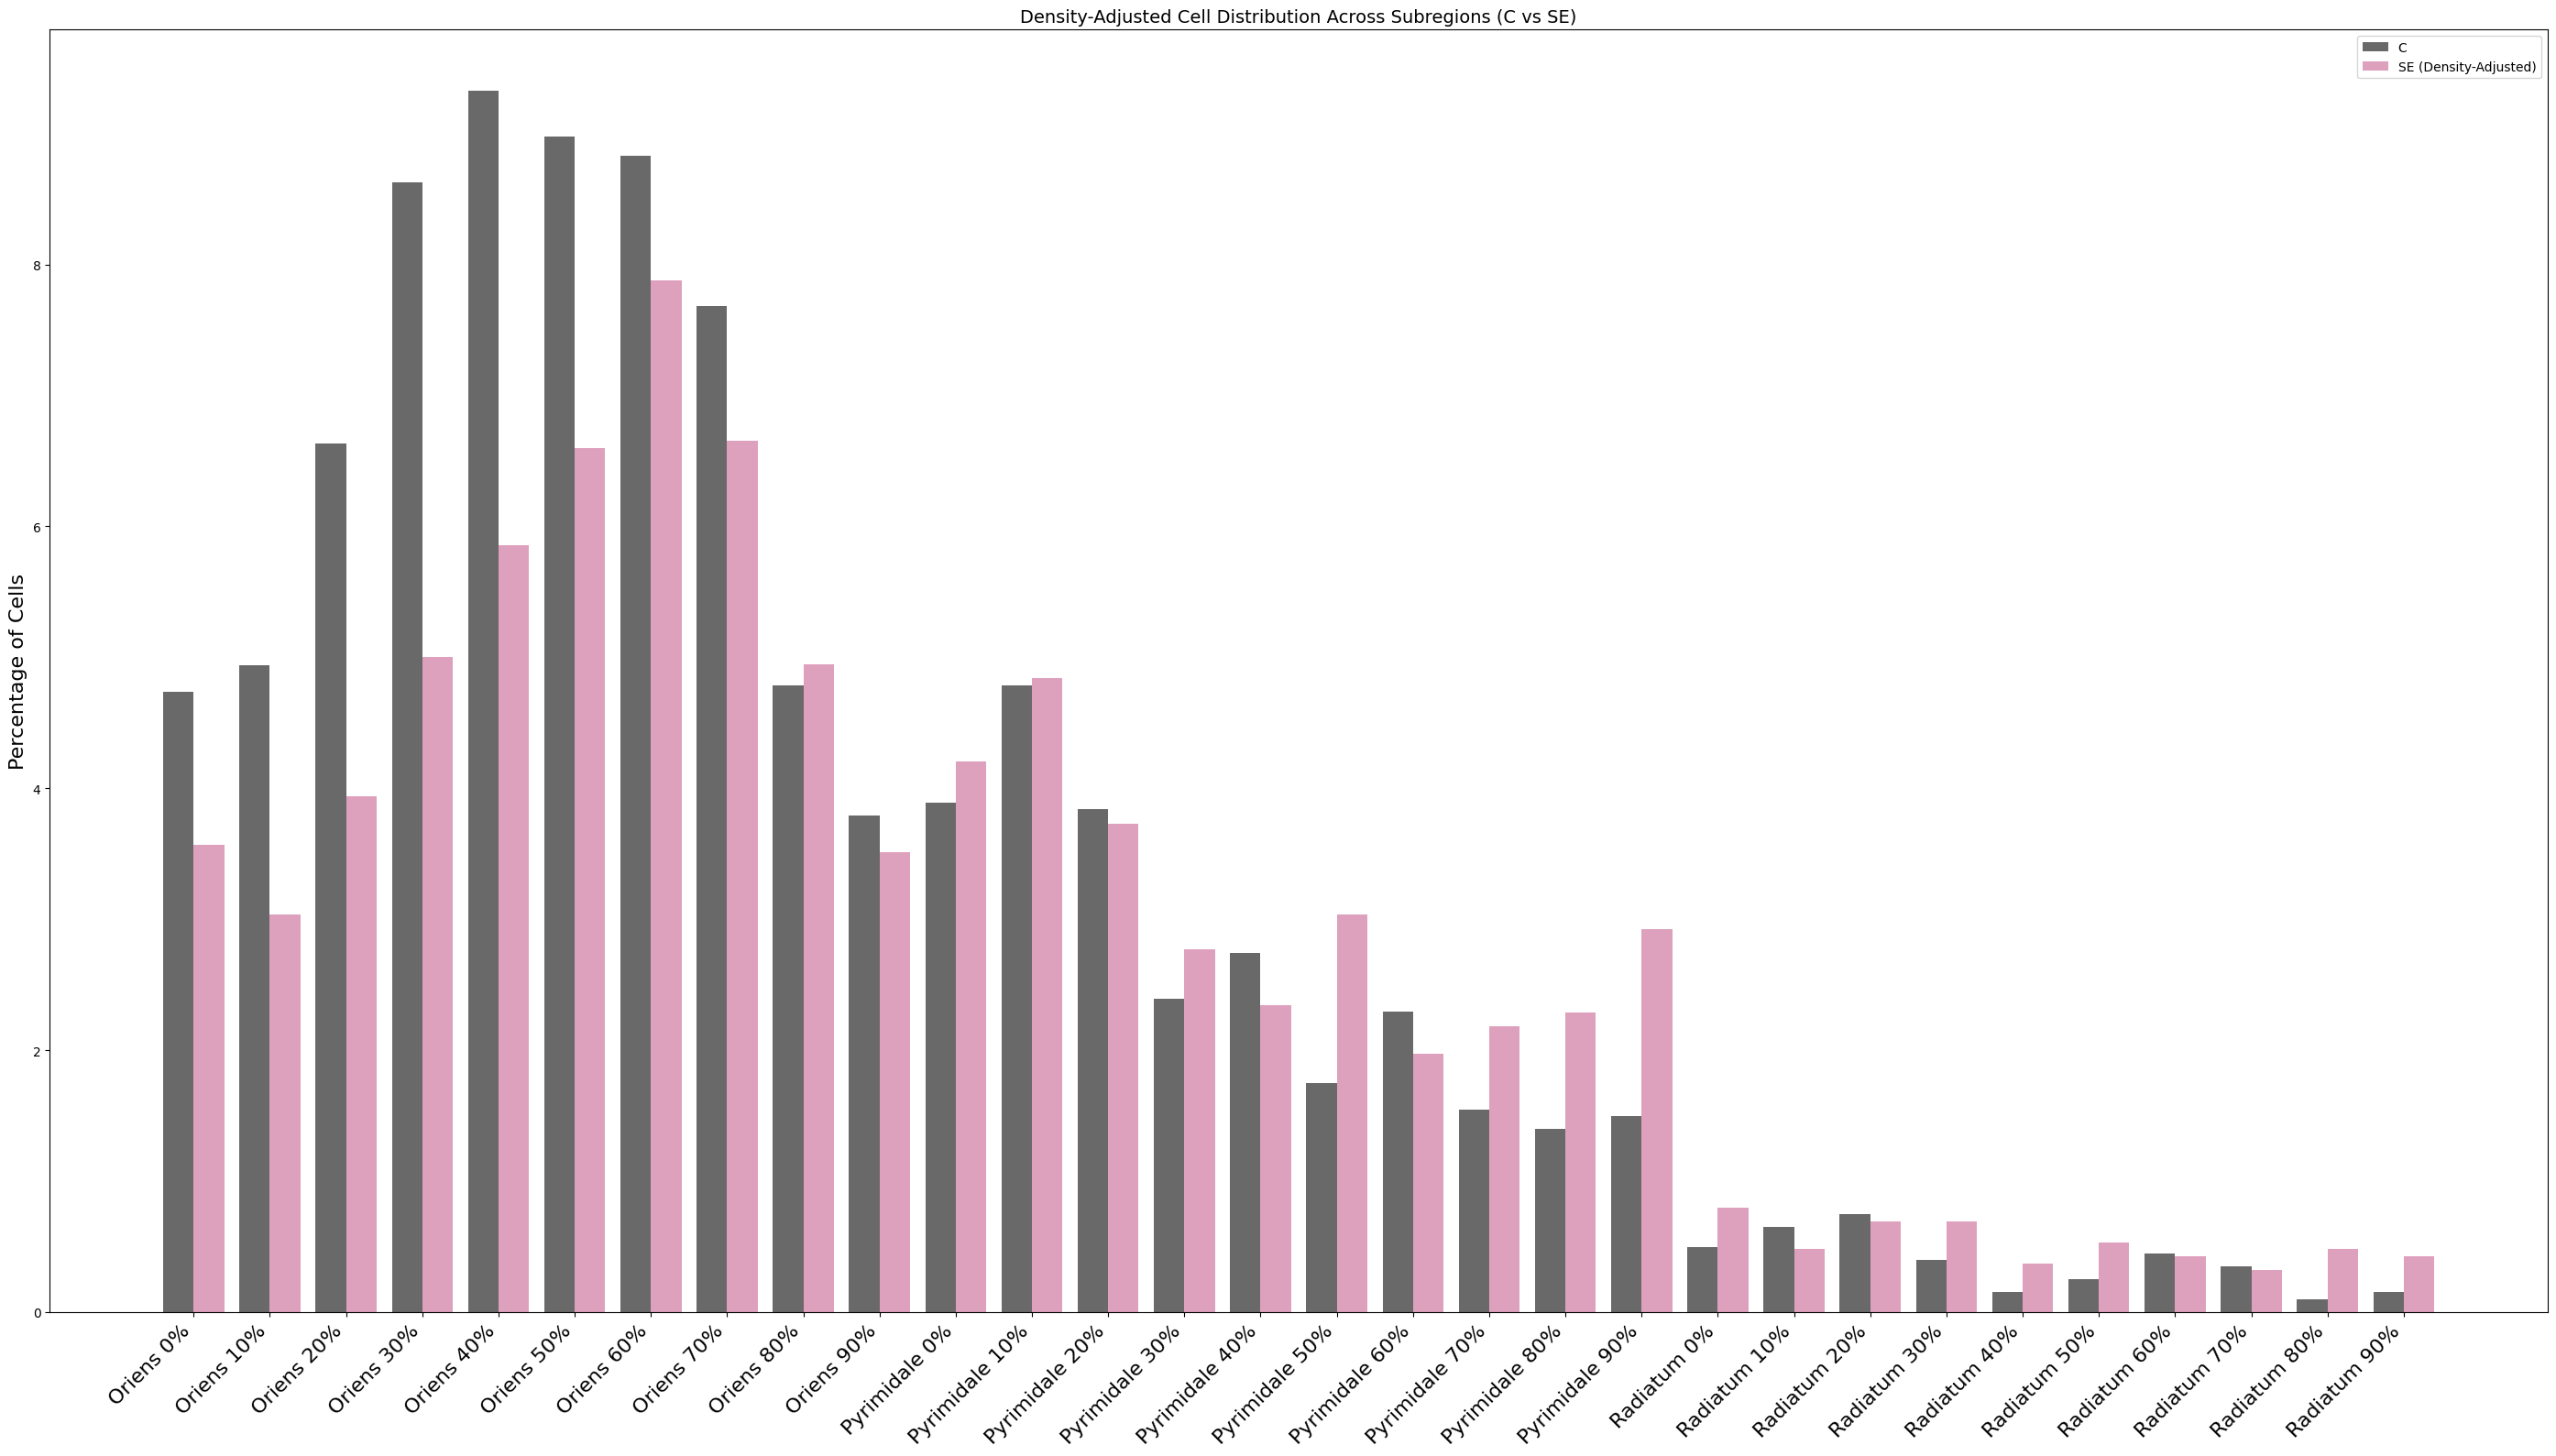

Saved density-adjusted bars →
 • D:\PSM\SST_images\SST3\results\density_adjusted_distribution.png
 • D:\PSM\SST_images\SST3\results\density_adjusted_distribution.svg


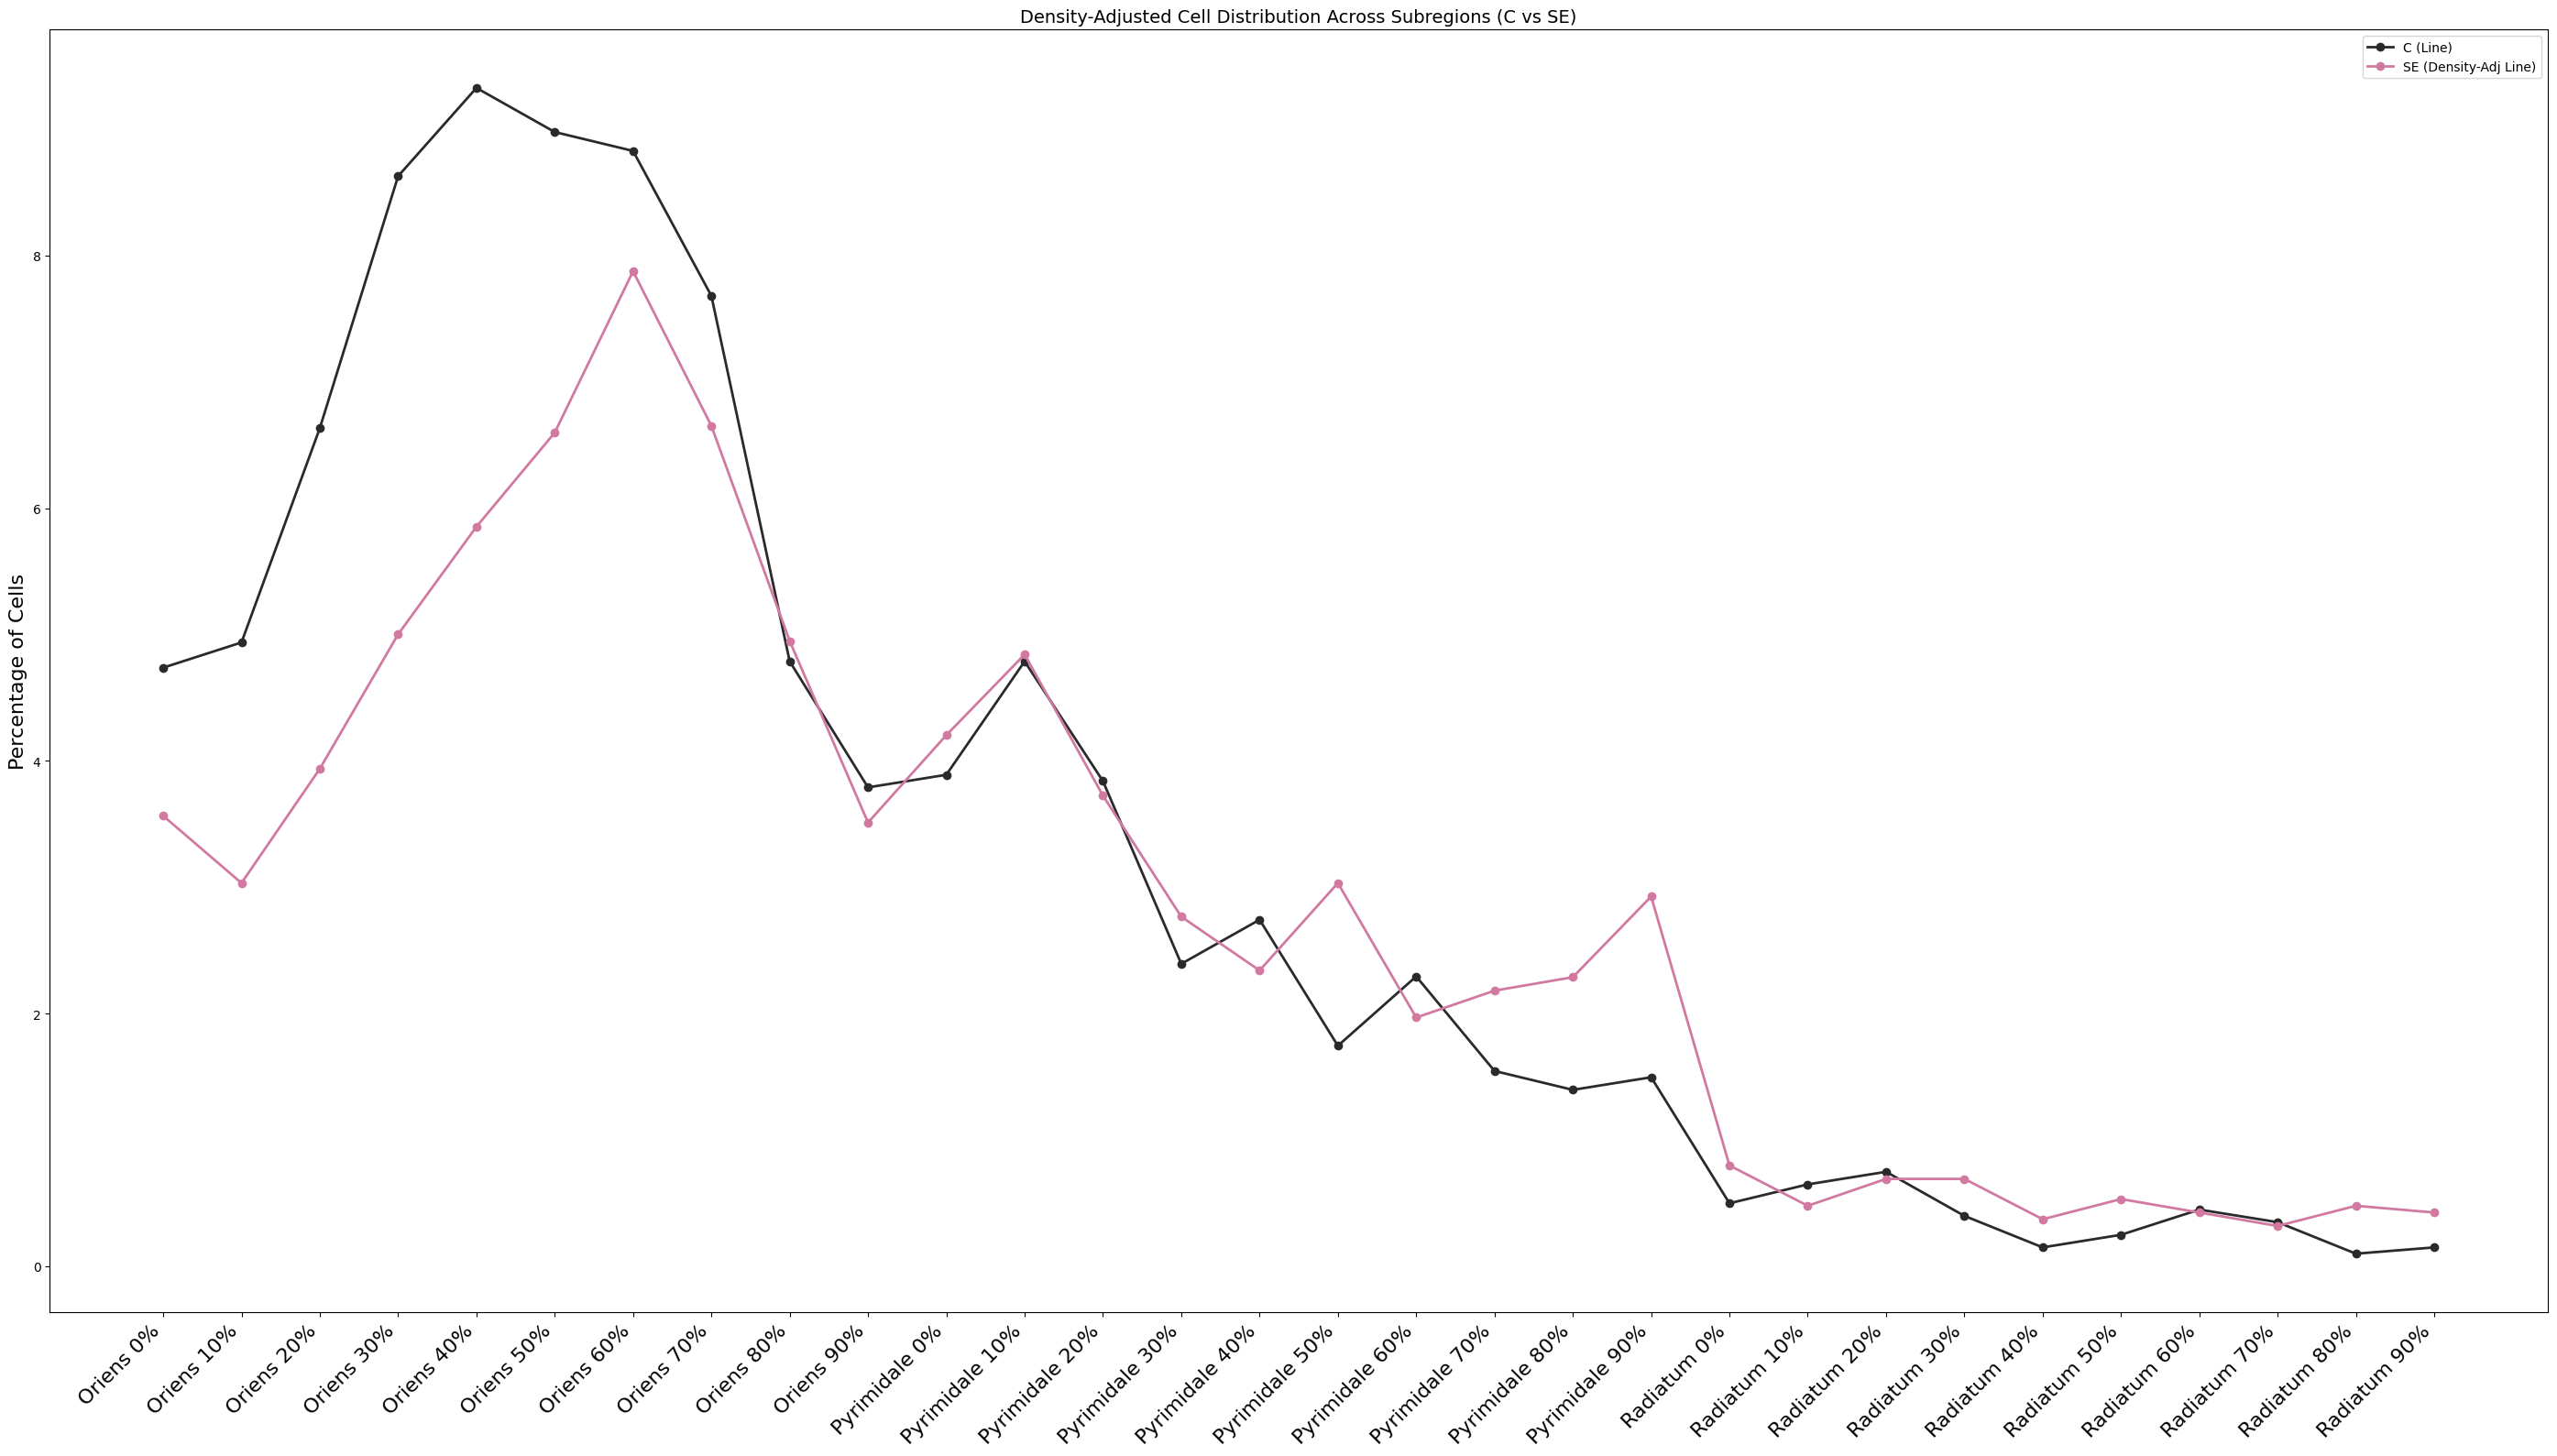

Saved density-adjusted lines →
 • D:\PSM\SST_images\SST3\results\density_adjusted_distribution_line.png
 • D:\PSM\SST_images\SST3\results\density_adjusted_distribution_line.svg


In [7]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell 7: Density-Adjusted Distribution → Bar & Line + Save to Disk
# ─────────────────────────────────────────────────────────────────────────────

# --- 1) get raw percent distributions (must have sub_dist, df_C, df_SE in scope) ---
labels_C, dist_C, _  = sub_dist(df_C)
_,        dist_SE, _ = sub_dist(df_SE)

# --- 2) compute density ratio (cells/mm²) from group_densities ---
density_ratio = group_densities['SE'] / group_densities['C']

# --- 3) cast to array and apply adjustment ---
dist_SE_adj = np.array(dist_SE) * density_ratio

# --- shared X positions and width ---
x = np.arange(len(labels_C))
w = 0.4

# --- results directory from your config ---
results_dir = os.path.dirname(RESULTS_XLSX)

# ─── Bar Chart ────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(28, 16))
ax.bar(x - w/2, dist_C,     w, label='C',                      color='#2a2a2a', alpha=0.7)
ax.bar(x + w/2, dist_SE_adj, w, label='SE (Density-Adjusted)', color='#d179a1', alpha=0.7)

ax.set_xticks(x)
ax.set_xticklabels(labels_C, rotation=45, ha='right', fontsize=16)
ax.set_ylabel('Percentage of Cells', fontsize=16)
ax.set_title('Density-Adjusted Cell Distribution Across Subregions (C vs SE)', fontsize=14)
ax.legend()
plt.tight_layout()

# save bar chart
bar_png = os.path.join(results_dir, "density_adjusted_distribution.png")
bar_svg = os.path.join(results_dir, "density_adjusted_distribution.svg")
fig.savefig(bar_png, dpi=300)
fig.savefig(bar_svg)

# show bar chart
plt.show()

print(f"Saved density-adjusted bars →\n • {bar_png}\n • {bar_svg}")

# ─── Line Chart ────────────────────────────────────────────────────────────────
fig2, ax2 = plt.subplots(figsize=(28, 16))
ax2.plot(x, dist_C,      marker='o', linewidth=2, color='#2a2a2a', label='C (Line)')
ax2.plot(x, dist_SE_adj, marker='o', linewidth=2, color='#d179a1', label='SE (Density-Adj Line)')

ax2.set_xticks(x)
ax2.set_xticklabels(labels_C, rotation=45, ha='right', fontsize=16)
ax2.set_ylabel('Percentage of Cells', fontsize=16)
ax2.set_title('Density-Adjusted Cell Distribution Across Subregions (C vs SE)', fontsize=14)
ax2.legend()
plt.tight_layout()

# save line chart
line_png = os.path.join(results_dir, "density_adjusted_distribution_line.png")
line_svg = os.path.join(results_dir, "density_adjusted_distribution_line.svg")
fig2.savefig(line_png, dpi=300)
fig2.savefig(line_svg)

# show line chart
plt.show()

print(f"Saved density-adjusted lines →\n • {line_png}\n • {line_svg}")


In [8]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell 8: Excel pivot table
# ─────────────────────────────────────────────────────────────────────────────

# ── Define paths to match prior outputs ──
RESULTS_XLSX = r"D:\PSM\SST_images\SST3\results\processed_results.xlsx"
ROI_MEASURE_CSV = r"D:\PSM\SST_images\SST3\avg\roi_measurements.csv"

# ── Load input files ──
df_C = pd.read_excel(RESULTS_XLSX, sheet_name='C')
df_SE = pd.read_excel(RESULTS_XLSX, sheet_name='SE')
roi_areas = pd.read_csv(ROI_MEASURE_CSV)

# ── Clean and reshape ROI areas ──
roi_areas['base_id'] = roi_areas['Filename'].str.extract(r'(PSM_[A-Z]_CA1_10x_\d{2})')[0]
roi_areas_pivot = roi_areas.pivot(index='base_id', columns='ROI', values='Area (microns)').reset_index()

# Rename ROI columns to standard names
rename_map = {
    col: (
        'Area_full' if 'full' in col.lower() else
        'Area_oriens' if 'oriens' in col.lower() else
        'Area_pyrimidale' if 'pyrimidale' in col.lower() else
        'Area_radiatum' if 'radiatum' in col.lower() else col
    )
    for col in roi_areas_pivot.columns
}
roi_areas_pivot = roi_areas_pivot.rename(columns=rename_map)

# ── Function to aggregate by BaseID and compute densities ──
def process_group_data(group_df, roi_areas):
    grouped = group_df.groupby(['base_id', 'ROI'])['obj_idx'].count().reset_index()
    grouped = grouped.pivot(index='base_id', columns='ROI', values='obj_idx').fillna(0)
    grouped.columns = [f"Objects_{col}" for col in grouped.columns]

    for region in ['oriens', 'pyrimidale', 'radiatum']:
        col = f"Objects_{region}"
        if col not in grouped.columns:
            grouped[col] = 0

    grouped['Objects_full'] = grouped[['Objects_oriens', 'Objects_pyrimidale', 'Objects_radiatum']].sum(axis=1)

    merged = grouped.merge(roi_areas, on='base_id', how='left')

    for region in ['full', 'oriens', 'pyrimidale', 'radiatum']:
        a_col = f'Area_{region}'
        o_col = f'Objects_{region}'
        d_col = f'Density_{region} (obj/mm²)'
        if a_col in merged.columns and o_col in merged.columns:
            merged[d_col] = merged[o_col] / (merged[a_col] * 1e-6)

    merged = merged.reset_index()
    merged['PSM_Letter'] = merged['base_id'].str.extract(r'PSM_([A-Z])_')[0]
    merged['PSM_Number'] = merged['base_id'].str.extract(r'_(\d{2})$')[0].astype(int)

    merged = merged.sort_values(by=['PSM_Letter', 'PSM_Number'])

    avg = merged.groupby('PSM_Letter').median(numeric_only=True).reset_index() # MEDIAN - Can change to MEAN
    avg['base_id'] = avg['PSM_Letter'] + '_avg'
    avg = avg.drop(columns=['PSM_Number'])

    merged = pd.concat([merged, avg], ignore_index=True)

    return merged

# ── Process both groups and write to Excel ──
df_C_processed = process_group_data(df_C, roi_areas_pivot)
df_SE_processed = process_group_data(df_SE, roi_areas_pivot)

with pd.ExcelWriter(RESULTS_XLSX, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    df_C_processed.to_excel(writer, sheet_name='C_Object_Area_Density', index=False)
    df_SE_processed.to_excel(writer, sheet_name='SE_Object_Area_Density', index=False)


print(f"✅ Saved area and density calculations to:\n• {RESULTS_XLSX}")


✅ Saved area and density calculations to:
• D:\PSM\SST_images\SST3\results\processed_results.xlsx


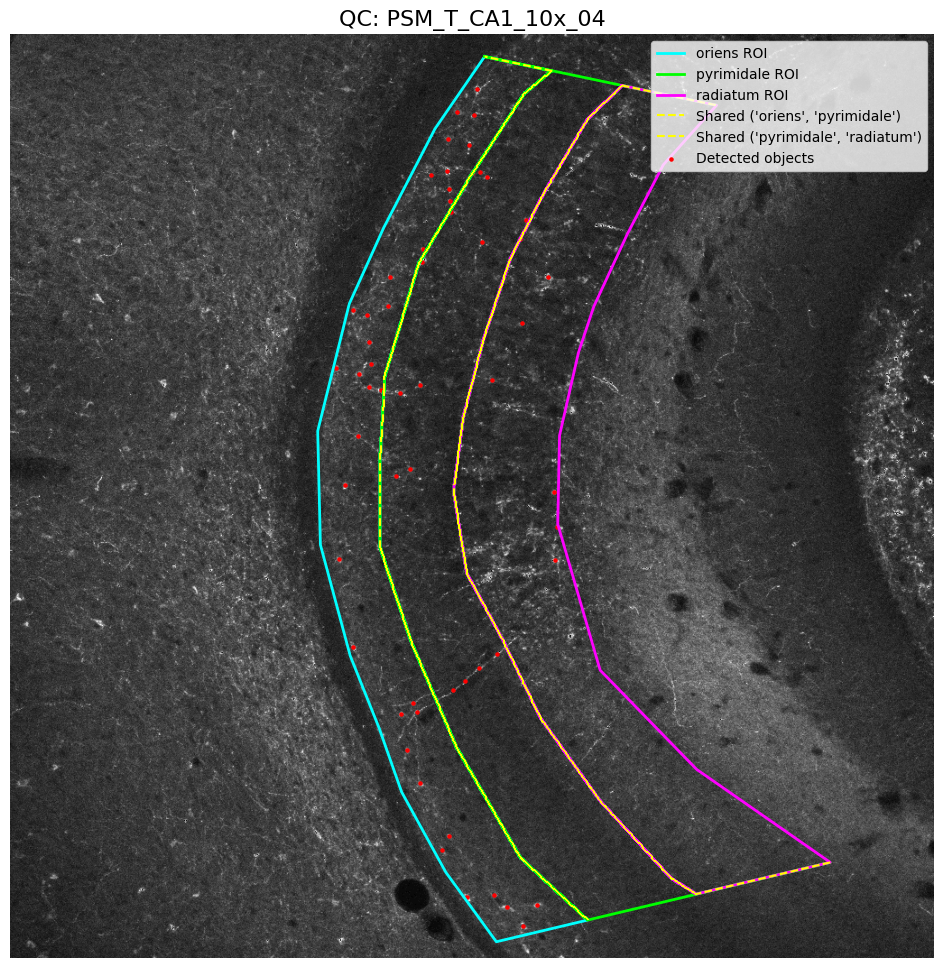

In [9]:
def round_coordinates(coords):
    return np.round(coords).astype(int)
def qc_plot(base_id):
    # Load the average image
    image_path = os.path.join(AVG_DIR, f"Red_{base_id}.tif")
    image = Image.open(image_path)

    # Load ROIs and boundaries
    rois = load_roi_polygons(base_id)
    shared = calculate_shared_boundaries(rois)

    # Load all results and filter
    results = pd.concat(pd.read_excel(RESULTS_XLSX, sheet_name=['C', 'SE']).values(), ignore_index=True)
    pts = results[results['base_id'] == base_id][['X', 'Y']].values.tolist()

    # Plot
    fig, ax = plt.subplots(figsize=(12, 12))
    brightness_factor = 10
    bright = np.clip(np.array(image) * brightness_factor, 0, 255).astype(np.uint8)
    ax.imshow(bright, cmap='gray', extent=[0, image.width, image.height, 0])

    # Draw ROIs
    colors = {'oriens': 'cyan', 'pyrimidale': 'lime', 'radiatum': 'magenta'}
    for name, poly in rois.items():
        x, y = poly.exterior.xy
        ax.plot(x, y, color=colors.get(name, 'white'), lw=2, label=f"{name} ROI")

    # Draw shared boundaries
    for key, boundary in shared.items():
        if boundary and not boundary.is_empty:
            lines = boundary.geoms if boundary.geom_type == 'MultiLineString' else [boundary]
            for ln in lines:
                x, y = ln.xy
                ax.plot(x, y, '--', color='yellow', label=f"Shared {key}")

    # Draw object positions
    if pts:
        xs, ys = zip(*pts)
        ax.scatter(xs, ys, c='red', s=5, label='Detected objects')

    ax.set_title(f"QC: {base_id}", fontsize=16)
    ax.axis('off')

    # Deduplicate legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right')

    plt.show()
def round_coordinates(coords):
    return np.round(coords).astype(int)

def load_roi_polygons(base_id):
    paths   = generate_file_paths(base_id)
    pyr_path = os.path.join(REFINED_PYR_DIR, f"Red_{base_id}_s_pyrimidale.roi")

    # raw coords
    ori_coords = ImagejRoi.fromfile(paths['oriens_roi']).coordinates()
    pyr_coords = ImagejRoi.fromfile(pyr_path).coordinates()
    rad_coords = ImagejRoi.fromfile(paths['radiatum_roi']).coordinates()

    # build & repair
    ori_poly = _make_valid(Polygon(round_coordinates(ori_coords)))
    pyr_poly = _make_valid(Polygon(round_coordinates(pyr_coords)))
    rad_poly = _make_valid(Polygon(round_coordinates(rad_coords)))

    return {
        'oriens'    : ori_poly,
        'pyrimidale': pyr_poly,
        'radiatum'  : rad_poly
    }


qc_plot("PSM_T_CA1_10x_04")
